In [260]:
import os

from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import cv2 as cv
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F



for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Things to include in the notebook
- Difference between training on the same dataset(s) and crossing dataset
- Try to have it random if it should train on an image from MNIST or SVHN. 
- Try training with different types of preprocessing and data augmentation


# Startphase

## Loading the MNIST dataset


In [261]:
mnist_train_dataset = torchvision.datasets.MNIST(root="data", download=True, transform=ToTensor(), train=True)

## Loading the SVHN dataset

In [262]:
svhn_train_dataset = torchvision.datasets.SVHN(root="data", split='train', download=True, transform=ToTensor())

Using downloaded and verified file: data/train_32x32.mat


## Visualizing the MNIST dataset

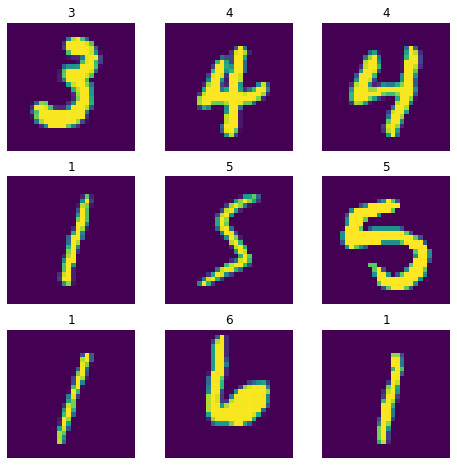

In [263]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(mnist_train_dataset), size=(1,)).item()
    img, label = mnist_train_dataset[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## Visualizing the SVHN dataset

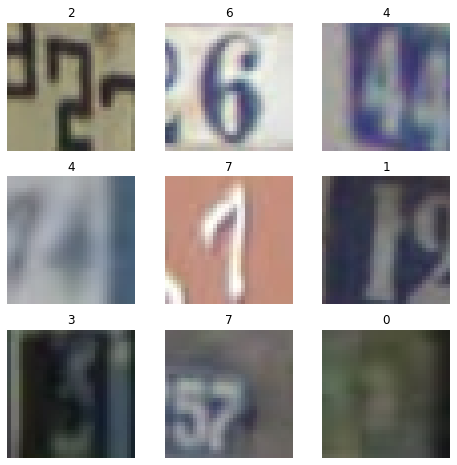

In [264]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(svhn_train_dataset), size=(1,)).item()
    img, label = svhn_train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    ax1 = figure.add_subplot(rows, cols, i)
    ax1.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

## Creating 2d-array with all the tensors based on label

In [265]:
num_classes = len(mnist_train_dataset.classes)

mnist_idx_by_class = [np.where(mnist_train_dataset.targets == i)[0] for i in range(0, num_classes)]
svhn_idx_by_class = [np.where(svhn_train_dataset.labels == i)[0] for i in range(0, num_classes)]

## Inspecting same label images from the two datasets

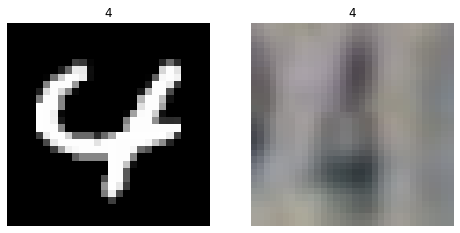

In [266]:
random_class = np.random.randint(0, num_classes)

mnist_idx = random.choice(mnist_idx_by_class[random_class])
svhn_idx = random.choice(svhn_idx_by_class[random_class])

figure = plt.figure(figsize=(8, 8))
mnist_img = mnist_train_dataset.data[mnist_idx]
svhn_img = svhn_train_dataset.data[svhn_idx]


ax = figure.add_subplot(1, 2, 1)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(mnist_img.squeeze(), cmap="gray")
ax = figure.add_subplot(1, 2, 2)
ax.set_title(random_class)
plt.axis("off")
plt.imshow(svhn_img.transpose(1, 2, 0))

plt.show()



## Visualizing the distribution of labels from both datasets

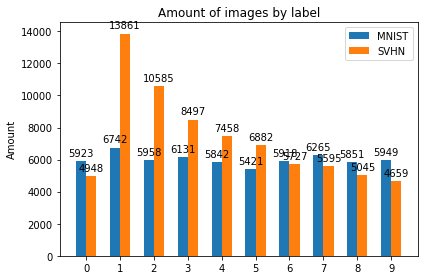

In [267]:
labels = np.arange(0, 10)
len_mnist = [len(x) for x in mnist_idx_by_class]
len_svhn = [len(x) for x in svhn_idx_by_class]

width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width / 2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width / 2, len_svhn, width, label='SVHN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Data preprocessing - Exploration phase


## Grayscale



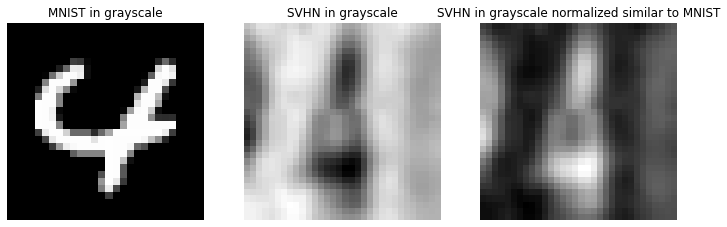

In [268]:
gray_svhn = T.Grayscale()(torch.from_numpy(svhn_img))

gray_svhn2 = gray_svhn

gray_svhn = torch.movedim(gray_svhn, 0, 2)

gray_svhn2 = gray_svhn2.detach().numpy()
gray_svhn2 = cv.normalize(gray_svhn2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
gray_svhn2 = 255 - gray_svhn2

figure = plt.figure(figsize=(12, 8))
ax = figure.add_subplot(2, 3, 1)
plt.axis("off")
ax.set_title("MNIST in grayscale")
plt.imshow(mnist_img.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 3, 2)
plt.axis("off")
ax.set_title("SVHN in grayscale")
plt.imshow(gray_svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 3, 3)
plt.axis("off")
ax.set_title("SVHN in grayscale normalized similar to MNIST")
plt.imshow(gray_svhn2.squeeze(), cmap="gray")

plt.show()


## Threshold


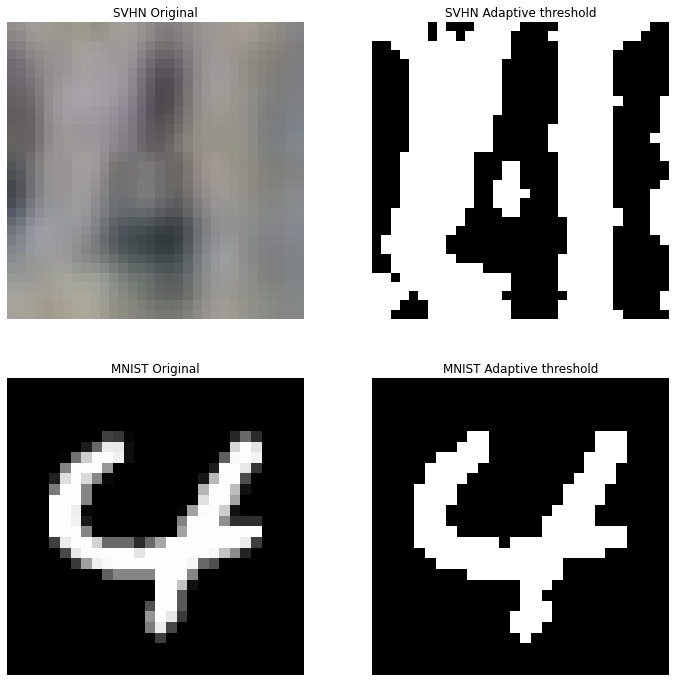

In [269]:
svhn = svhn_img.transpose(1, 2, 0)
mnist = mnist_img.detach().numpy()

svhn_grey = cv.cvtColor(svhn, cv.COLOR_BGR2GRAY)
svhn_grey = cv.normalize(svhn_grey, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
svhn_grey = svhn_grey.astype(np.uint8)

#Should find a good number for reduction on adaptive threshold, e.g. the last number
svhn_threshold = cv.adaptiveThreshold(svhn_grey, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)
#svhn_threshold = cv.bitwise_not(svhn_threshold)

#Threshold reduction number needs to be 0 on mnist
mnist = cv.normalize(mnist, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
mnist = mnist.astype(np.uint8)
mnist_threshold = cv.adaptiveThreshold(mnist, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(12, 12))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("SVHN Original")
plt.axis("off")
plt.imshow(svhn, cmap="gray")

ax = figure.add_subplot(2, 2, 2)
ax.set_title("SVHN Adaptive threshold")
plt.axis("off")
plt.imshow(svhn_threshold, cmap="gray")

ax = figure.add_subplot(2, 2, 3)
ax.set_title("MNIST Original")
plt.axis("off")
plt.imshow(mnist, cmap="gray")

ax = figure.add_subplot(2, 2, 4)
ax.set_title("MNIST Adaptive threshold")
plt.axis("off")
plt.imshow(mnist_threshold, cmap="gray")

plt.show()

## Equalize Hist and CLAHE

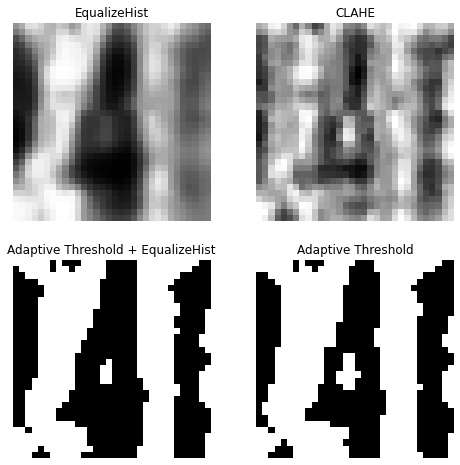

In [270]:
image = svhn

image = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = image.astype(np.uint8)

image2 = image
image4 = image

image = cv.equalizeHist(image)
clahe = cv.createCLAHE(clipLimit=3., )
image2 = clahe.apply(image2)

image3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
image4 = cv.adaptiveThreshold(image4, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 0)

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("EqualizeHist")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 2)
ax.set_title("CLAHE")
plt.axis("off")
plt.imshow(image2.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 3)
ax.set_title("Adaptive Threshold + EqualizeHist")
plt.axis("off")
plt.imshow(image3.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 4)
ax.set_title("Adaptive Threshold")
plt.axis("off")
plt.imshow(image4.squeeze(), cmap="gray")


## Clearing up variables

In [271]:
del svhn_idx_by_class
del svhn_train_dataset
del mnist_idx_by_class
del mnist_train_dataset

# Defining the model

### Using CUDA if possible

In [272]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Defining the loss function

In [273]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2)
            + label
            * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )

        return loss_contrastive

## Defining siamese network model¶

In [274]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16 * 7 * 7, 10)
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

## Setting up the custom dataset

In [321]:
class SiameseDataset(Dataset):
    def __init__(self, train: bool, mnist=False, svhn=False, mix=False):
        self.mnist_dataset = None
        self.svhn_dataset = None

        if mnist:
            self.mnist_dataset = torchvision.datasets.MNIST("files", train=train, download=True,
                                                        transform=torchvision.transforms.ToTensor())
        if svhn:
            if train:
                split = "train"
            else:
                split = "test"

            self.svhn_dataset = torchvision.datasets.SVHN(root="data", split=split, download=True, transform=ToTensor())
            self.svhn_dataset.data = self.svhn_dataset.data.transpose(0, 2, 3, 1)

        # used to prepare the labels and images path
        self.pairs = make_pairs(mix, self.mnist_dataset, self.svhn_dataset)

        self.dataset = [self.mnist_dataset] + [self.svhn_dataset]

    def __getitem__(self, index):

        dataset_index, item_index = self.pairs[index][0]
        pair_dataset_index, pair_index = self.pairs[index][1]
        matching = self.pairs[index][2]
        print(type( self.dataset[dataset_index].data[item_index]))
        print(type(self.dataset[pair_dataset_index].data[pair_index]))

        return self.dataset[dataset_index].data[item_index].float().unsqueeze(0), self.dataset[pair_dataset_index].data[
            pair_index].float().unsqueeze(0), matching


    def __len__(self):
        return len(self.pairs)

    def svhn_inverse_greyscale(self):
        for image in self.svhn_dataset.data:
            gray_svhn = T.Grayscale()(torch.from_numpy(image))
            normalized = cv.normalize(gray_svhn, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
            gray_svhn2 = 255 - gray_svhn2



def make_pairs(mix, mnist = None, svhn = None):
    pairs = []

    num_classes = 10

    if mix and mnist and svhn:
        return mix_pairs(mnist, num_classes, svhn)
    if svhn:
        svhn_labels = svhn.labels
        svhn_idx = [np.where(svhn_labels == i)[0] for i in range(0, num_classes)]
        dataset_pos = 1

        for anchor_idx in range(len(svhn_labels)):
            label = svhn_labels[anchor_idx]

            pos_idx = np.random.choice(svhn_idx[label])

            pairs.append([(dataset_pos, anchor_idx), (dataset_pos, pos_idx), 0])

            negative_label = np.random.randint(0, num_classes)
            while negative_label == label:
                negative_label = np.random.randint(0, num_classes)

            neg_idx = np.random.choice(svhn_idx[negative_label])

            pairs.append([(dataset_pos, anchor_idx), (dataset_pos, neg_idx), 1])
    if mnist:
        ##TODO start from prev index in pairs
        mnist_labels = mnist.targets
        mnist_idx = [np.where(mnist_labels == i)[0] for i in range(0, num_classes)]
        dataset_pos = 0

        for anchor_idx in range(len(mnist_labels)):
            label = mnist_labels[anchor_idx]

            pos_idx = np.random.choice(mnist_idx[label])

            pairs.append([(dataset_pos, anchor_idx), (dataset_pos, pos_idx), 0])

            negative_label = np.random.randint(0, num_classes)
            while negative_label == label:
                negative_label = np.random.randint(0, num_classes)

            neg_idx = np.random.choice(mnist_idx[negative_label])

            pairs.append([(dataset_pos, anchor_idx), (dataset_pos, neg_idx), 1])

    return pairs

def add_pairs_mix(dataset_labels, dataset_pos, mnist_idx, svhn_idx):
    pairs = []
    for anchor_idx in range(len(dataset_labels)):
        mnist_label = dataset_labels[anchor_idx]

        dataset_choice = np.random.randint(0, 2)
        #0 = MNIST, 1 = SVHN

        if dataset_choice == 0:
            pos_idx = np.random.choice(mnist_idx[mnist_label])
        else:
            pos_idx = np.random.choice(svhn_idx[mnist_label])

        pairs.append([(dataset_pos, anchor_idx), (dataset_choice, pos_idx), 0])

        negative_label = np.random.randint(0, num_classes )
        while negative_label == mnist_label:
            negative_label = np.random.randint(0, num_classes)

        dataset_choice = np.random.randint(0, 2)

        if dataset_choice == 0:
            neg_idx = np.random.choice(mnist_idx[negative_label])
        else:
            neg_idx = np.random.choice(svhn_idx[negative_label])

        pairs.append([(dataset_pos, anchor_idx), (dataset_choice, neg_idx), 1])
    return pairs

# TODO: Consider cleaning up this into a single for loop instead
def mix_pairs(mnist, num_classes, svhn):
    pairs = []
    ### Add mixing of datasets
    mnist_labels = mnist.targets
    svhn_labels = svhn.labels
    mnist_idx = [np.where(mnist_labels == i)[0] for i in range(0, num_classes)]
    svhn_idx = [np.where(svhn_labels == i)[0] for i in range(0, num_classes)]
    mnist_dataset_pos = 0
    svhn_dataset_pos = 1

    pairs = pairs + add_pairs_mix(mnist_labels, mnist_dataset_pos, mnist_idx, svhn_idx)

    pairs = pairs + add_pairs_mix(svhn_labels, svhn_dataset_pos, mnist_idx, svhn_idx)

    return pairs

## Setting up training

### Inspecting the pairs

Using downloaded and verified file: data/train_32x32.mat


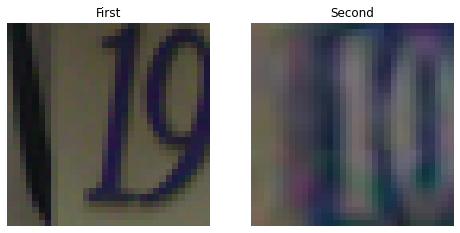

In [309]:
train_dataset = SiameseDataset(train=True, mnist=True, svhn=True, mix=True)

first_item, second_item, similar = train_dataset.__getitem__(120000)

figure = plt.figure(figsize=(8, 8))

ax = figure.add_subplot(1, 2, 1)
ax.set_title("First")
plt.axis("off")
plt.imshow(first_item.squeeze(), cmap="gray")

ax = figure.add_subplot(1, 2, 2)
ax.set_title("Second")
plt.axis("off")
plt.imshow(second_item.squeeze(), cmap="gray")

In [317]:
epochs = 20
train_dataset = SiameseDataset(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = SiameseDataset(train=False)
val_dataset.pre_grey()
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

net = SiameseNetwork()
contrastive_loss = ContrastiveLoss()
adam = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)


def train(model, optimizer, criterion, dataloader):
    model.train()

    loss = []

    for img1, img2, label in dataloader:
        optimizer.zero_grad()

        output1, output2 = model(img1, img2)

        loss_contrastive = criterion(output1, output2, label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())

    loss = np.array(loss)
    return loss.mean() / len(dataloader)


def save_model(model, name):
    model.eval()
    # Input to the model
    example1 = torch.randn(1, 1, 28, 28)
    example2 = torch.randn(1, 1, 28, 28)
    traced_script_module = torch.jit.trace(model.cpu(), (example1, example2))
    torch.jit.save(traced_script_module, name)


def test(model, criterion, dataloader):
    model.eval()
    loss = []

    with torch.no_grad():
        for img1, img2, label in dataloader:
            output1, output2 = net(img1, img2)

            loss_contrastive = criterion(output1, output2, label)
            loss.append(loss_contrastive.item())

        loss = np.array(loss)
    return loss.mean() / len(dataloader)


best_model = net
rounds_without_improvement = 0
best_loss = float('inf')

for epoch in range(epochs):
    print(f"--EPOCH {epoch+1}--")

    train_loss = train(model=net, optimizer=adam, criterion=contrastive_loss, dataloader=train_dataloader)
    print(f"Train loss {train_loss}")

    val_loss = test(model=net, criterion=contrastive_loss, dataloader=val_dataloader)
    print(f"Val loss {val_loss}")

    if (val_loss < best_loss):
        best_loss = val_loss
        best_model = net
        rounds_without_improvement = 0
    else:
        rounds_without_improvement += 1

    if (rounds_without_improvement > 3 or epoch == epochs-1):
        save_model(model=best_model, name=f"epoch{epoch}_model.pt")



ValueError: num_samples should be a positive integer value, but got num_samples=0

cpu
<class 'torch.Tensor'>
<class 'torch.Tensor'>


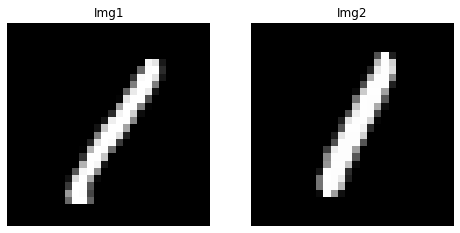

tensor([0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


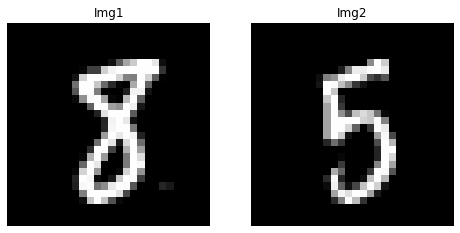

tensor([1])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


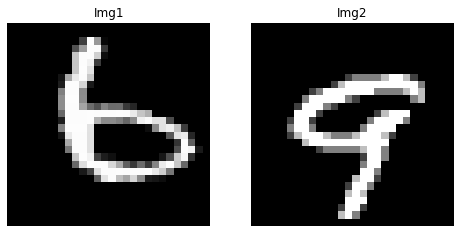

tensor([1])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


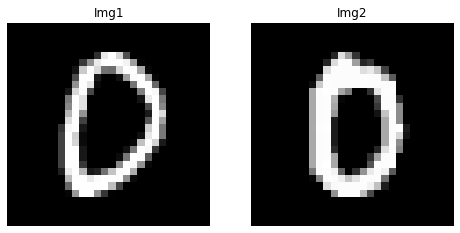

tensor([0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


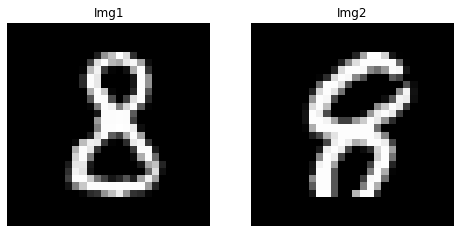

tensor([0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


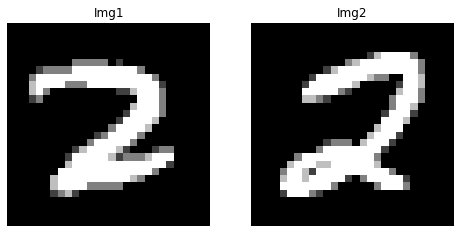

tensor([0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


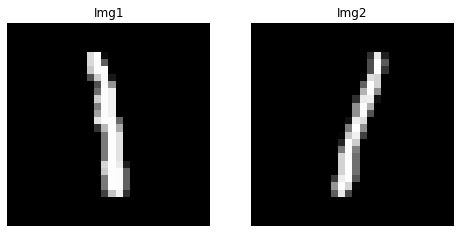

tensor([0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


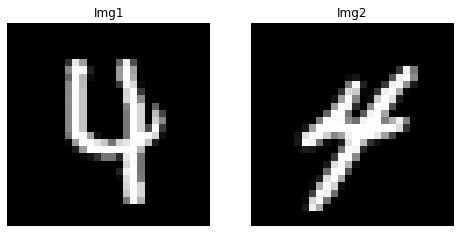

tensor([0])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


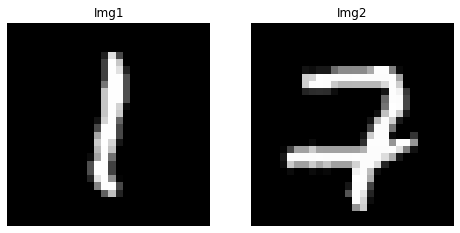

tensor([1])

<class 'torch.Tensor'>
<class 'torch.Tensor'>


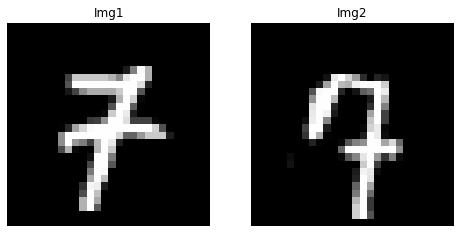

tensor([0])



In [325]:
print(device)
test_dataset = SiameseDataset(train=False, mnist=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

#model = torch.jit.load("epoch19_model.pt").to(device)

count = 1
for img1, img2, label in test_dataloader:
 #   output1, output2 = model(img1, img2)

    figure = plt.figure(figsize=(8, 8))

    ax = figure.add_subplot(1, 2, 1)
    ax.set_title("Img1")
    plt.axis("off")
    plt.imshow(img1.squeeze(), cmap="gray")
    ax = figure.add_subplot(1, 2, 2)
    ax.set_title("Img2")
    plt.axis("off")
    plt.imshow(img2.squeeze(), cmap="gray")

    plt.show()

    # if label == torch.FloatTensor([[0]]):
    #     label = "Same numbers"
    # else:
    #     label = "Different numbers"

    print(label)
    # print(F.pairwise_distance(output1, output2).item())
    print()

    count += 1
    if (count > 10):
        break